# Proyek Klasifikasi Gambar: Klasifikasi Gambar Hewan (Animals-10)
- **Nama:** Khatama Putra
- **Email:** m297d5y0968@student.devacademy.id
- **ID Dicoding:** khatamap

In [ ]:
!pip install pipreqs
!pipreqs "/content/drive/MyDrive/Colab Notebooks/BFDL_Khatama-Putra_CNN" --scan-notebooks

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install -q kaggle
!pip install -q split-folders
!pip install -q tensorflowjs

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import shutil
import splitfolders
import pathlib
import subprocess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.


## Data Preparation

### Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Membuat direktori .kaggle dan memindahkan file kaggle.json
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/BFDL_Khatama-Putra_CNN/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Setup Kaggle API selesai.")

Setup Kaggle API selesai.


In [4]:
!kaggle datasets download viratkothari/animal10

print("Dataset berhasil diunduh.")

Dataset URL: https://www.kaggle.com/datasets/viratkothari/animal10
License(s): GPL-2.0
 98% 576M/585M [00:05<00:00, 158MB/s]
100% 585M/585M [00:05<00:00, 113MB/s]
Dataset berhasil diunduh.


### Data Preprocessing

#### Split Dataset

In [5]:
zip_path = 'animal10.zip'
output_dir = 'animals_split'

if os.path.exists(output_dir): shutil.rmtree(output_dir)
if os.path.exists('Animals-10'): shutil.rmtree('Animals-10')

# Ekstrak
print("Mengekstrak dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Cari folder hasil ekstrak
base_dir = None
for item in os.listdir('.'):
    if os.path.isdir(item) and item not in ['.config', 'sample_data', '.kaggle', output_dir]:
        if len(os.listdir(item)) > 5:
            base_dir = item
            break

if base_dir:
    print(f"Dataset ditemukan di folder: '{base_dir}'")
    print(f"Kelas: {os.listdir(base_dir)}")

    # Split Data
    print(f"Membagi dataset ke '{output_dir}'...")
    splitfolders.ratio(base_dir, output=output_dir, seed=42, ratio=(.8, .1, .1))

    # Path
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    print("Setup Dataset Selesai!")
else:
    print("Error: Folder dataset tidak ditemukan setelah ekstrak.")

Mengekstrak dataset...
Dataset ditemukan di folder: 'Animals-10'
Kelas: ['elephant', 'horse', 'cow', 'chicken', 'sheep', 'butterfly', 'spider', 'dog', 'cat', 'squirrel']
Membagi dataset ke 'animals_split'...


Copying files: 26179 files [00:04, 5366.51 files/s]

Setup Dataset Selesai!


#### Image Augmentation

In [6]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 64

# Pakai preprocess_input bawaan MobileNetV2
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"Label Kelas: {class_names}")

Found 20938 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.
Label Kelas: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


## Modelling

In [7]:
# Base Model (Transfer Learning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False

model = Sequential([
    base_model,

    Conv2D(128, (3, 3), activation='relu', padding='same'),

    GlobalAveragePooling2D(),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(len(class_names), activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

/tmp/ipython-input-627243296.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 128)      │     1,474,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,768,266 (14.37 MB)

 Trainable params: 1,510,282 (5.76 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_animal_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [9]:
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.7685 - loss: 0.7667
Epoch 1: val_accuracy improved from -inf to 0.95625, saving model to best_animal_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 309s 877ms/step - accuracy: 0.7688 - loss: 0.7657 - val_accuracy: 0.9563 - val_loss: 0.1485
Epoch 2/20
  1/327 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.9062 - loss: 0.1881

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.95625 to 0.95703, saving model to best_animal_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9062 - loss: 0.1881 - val_accuracy: 0.9570 - val_loss: 0.1482
Epoch 3/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9315 - loss: 0.2256
Epoch 3: val_accuracy improved from 0.95703 to 0.96211, saving model to best_animal_model.keras
327/327 ━━━━━━━━━━━━━━━━━━━━ 266s 812ms/step - accuracy: 0.9316 - loss: 0.2256 - val_accuracy: 0.9621 - val_loss: 0.1260
Epoch 4/20
  1/327 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9219 - loss: 0.2118
Epoch 4: val_accuracy did not improve from 0.96211
327/327 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9219 - loss: 0.2118 - val_accuracy: 0.9609 - val_loss: 0.1266
Epoch 5/20
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.9397 - loss: 0.2010
Epoch 5: val_accuracy did not improve from 0.96211
327/327 ━━━━━━━━━━━━━━━━━━━━ 264s 807ms/step - accuracy: 0.9396 - loss: 0.2010 - va

## Evaluasi dan Visualisasi

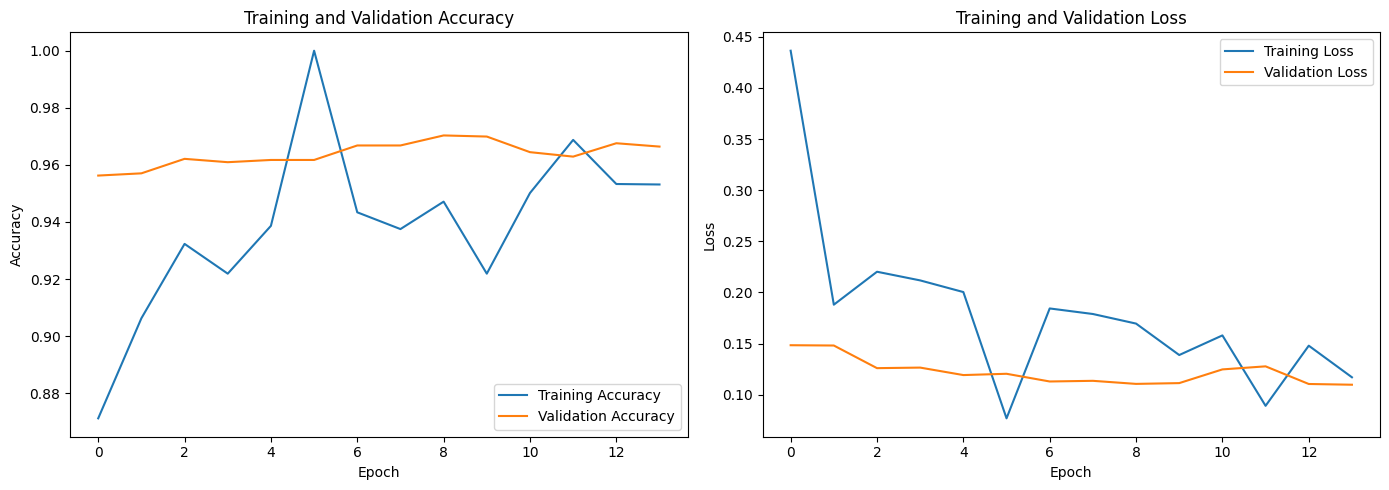

In [10]:
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
# Evaluasi model pada test set
print("Mengevaluasi model pada Test Set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\nTest Loss: {test_loss * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Mengevaluasi model pada Test Set...
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9569 - loss: 0.1508

Test Loss: 14.00%
Test Accuracy: 95.85%


## Konversi Model

In [12]:
output_save_path = "/content"

# SavedModel
saved_model_dir = 'animals_model_savedmodel'
saved_model_path = os.path.join(output_save_path, saved_model_dir)

model.export(saved_model_path)
print(f"✅ SavedModel berhasil diexport ke: {saved_model_path}")

zip_saved_model = os.path.join(output_save_path, saved_model_dir)
shutil.make_archive(zip_saved_model, 'zip', saved_model_path)

# TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

tflite_model_path = os.path.join(output_save_path, 'animals_model.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# TFJS
!pip install -q tensorflowjs
tfjs_dir = 'animals_model_tfjs'
tfjs_model_path = os.path.join(output_save_path, tfjs_dir)

if os.path.exists(tfjs_model_path):
    shutil.rmtree(tfjs_model_path)

command = f"tensorflowjs_converter --input_format=tf_saved_model {saved_model_path} {tfjs_model_path}"
subprocess.run(command, shell=True, check=True)

zip_tfjs = os.path.join(output_save_path, tfjs_dir)
shutil.make_archive(zip_tfjs, 'zip', tfjs_model_path)

# Download
files.download(tflite_model_path)
files.download(f"{zip_saved_model}.zip")
files.download(f"{zip_tfjs}.zip")

Saved artifact at '/content/animals_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139753035696272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035694928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035699536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035699152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035698000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035699728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035698192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035700304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035699920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139753035696080: TensorSpec(shape=(), dtype=tf.resource, name=

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [13]:
# Fungsi untuk memuat, memproses, dan memprediksi gambar
def predict_uploaded_image(model_to_use, class_names_list):
    uploaded = files.upload()

    for fn in uploaded.keys():
        path = fn

        img = image.load_img(path, target_size=TARGET_SIZE)

        plt.imshow(img)
        plt.axis('off')
        plt.show()

        img_array = image.img_to_array(img)

        img_array /= 255.0

        img_array = np.expand_dims(img_array, axis=0)

        predictions = model_to_use.predict(img_array)

        prediction_tensor = predictions['output_0'] if isinstance(predictions, dict) else predictions

        predicted_class_index = np.argmax(prediction_tensor[0])
        predicted_class_name = class_names_list[predicted_class_index]
        confidence = np.max(prediction_tensor[0]) * 100

        print(f"File: {fn}")
        print(f"Hasil Prediksi: {predicted_class_name}")
        print(f"Tingkat Keyakinan: {confidence:.2f}%")

tfsmlayer = tf.keras.layers.TFSMLayer(saved_model_path, call_endpoint='serving_default')
loaded_model = tf.keras.Sequential([tfsmlayer])

Saving Cat_November_2010-1a.png to Cat_November_2010-1a.png


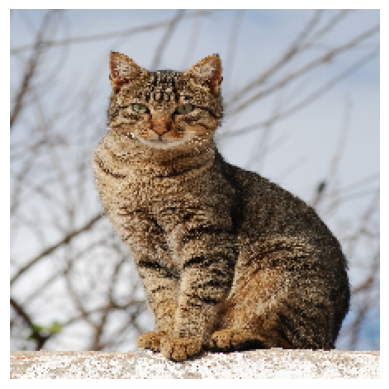

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
File: Cat_November_2010-1a.png
Hasil Prediksi: cat
Tingkat Keyakinan: 99.98%


In [14]:
predict_uploaded_image(loaded_model, class_names)

Saving cow-cut-out-black-white-600nw-25.png to cow-cut-out-black-white-600nw-25.png


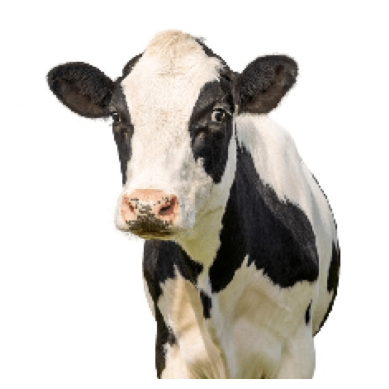

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
File: cow-cut-out-black-white-600nw-25.png
Hasil Prediksi: cow
Tingkat Keyakinan: 100.00%


In [15]:
predict_uploaded_image(loaded_model, class_names)

Saving wolf-spider.png to wolf-spider.png


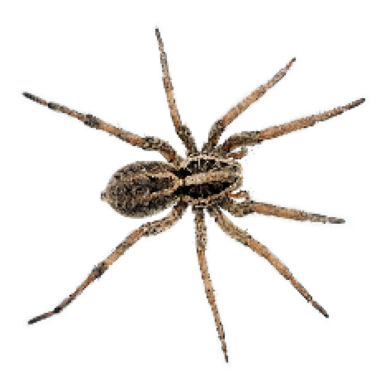

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
File: wolf-spider.png
Hasil Prediksi: spider
Tingkat Keyakinan: 100.00%


In [16]:
predict_uploaded_image(loaded_model, class_names)